## TabNet

In [1]:
!pip install pytorch-tabnet --quiet

In [127]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [134]:
dataset = load_iris()

X = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
y = pd.Series(data=dataset['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=.7, test_size=.3, stratify=y_train)

print(X_train.shape[0], X_valid.shape[0], X_test.shape[0])

84 36 30


In [135]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, 
    verbose=10)

clf.fit(
    X_train.values, y_train.values, 
    eval_set=[(X_valid.values, y_valid.values)],
    eval_name=['valid'],
    eval_metric=['accuracy', 'balanced_accuracy', 'logloss'],
    max_epochs=1_000,
    patience=40,
    batch_size=16
    )
y_pred = clf.predict(X_test.values)

Device used : cuda
epoch 0  | loss: 1.61712 | valid_accuracy: 0.33333 | valid_balanced_accuracy: 0.33333 | valid_logloss: 18.68886|  0:00:00s
epoch 10 | loss: 0.82421 | valid_accuracy: 0.33333 | valid_balanced_accuracy: 0.33333 | valid_logloss: 3.00154 |  0:00:01s
epoch 20 | loss: 0.47741 | valid_accuracy: 0.72222 | valid_balanced_accuracy: 0.72222 | valid_logloss: 1.22093 |  0:00:02s
epoch 30 | loss: 0.43946 | valid_accuracy: 0.77778 | valid_balanced_accuracy: 0.77778 | valid_logloss: 0.63134 |  0:00:04s
epoch 40 | loss: 0.34597 | valid_accuracy: 0.80556 | valid_balanced_accuracy: 0.80556 | valid_logloss: 0.3878  |  0:00:05s
epoch 50 | loss: 0.30391 | valid_accuracy: 0.91667 | valid_balanced_accuracy: 0.91667 | valid_logloss: 0.29037 |  0:00:06s
epoch 60 | loss: 0.16185 | valid_accuracy: 0.91667 | valid_balanced_accuracy: 0.91667 | valid_logloss: 0.27926 |  0:00:08s
epoch 70 | loss: 0.30058 | valid_accuracy: 0.94444 | valid_balanced_accuracy: 0.94444 | valid_logloss: 0.23694 |  0:00:0

In [136]:
valid_score = balanced_accuracy_score(
    y_true=y_valid.values, 
    y_pred=clf.predict(X_valid.values)
    )
test_score = balanced_accuracy_score(
    y_true=y_test.values, 
    y_pred=clf.predict(X_test.values)
    )

print(f"BEST VALID SCORE : {valid_score}")
print(f"FINAL TEST SCORE : {test_score}")

BEST VALID SCORE : 0.9722222222222222
FINAL TEST SCORE : 0.9333333333333332


In [137]:
clf.feature_importances_

array([0.09620335, 0.16944099, 0.35016209, 0.38419358])

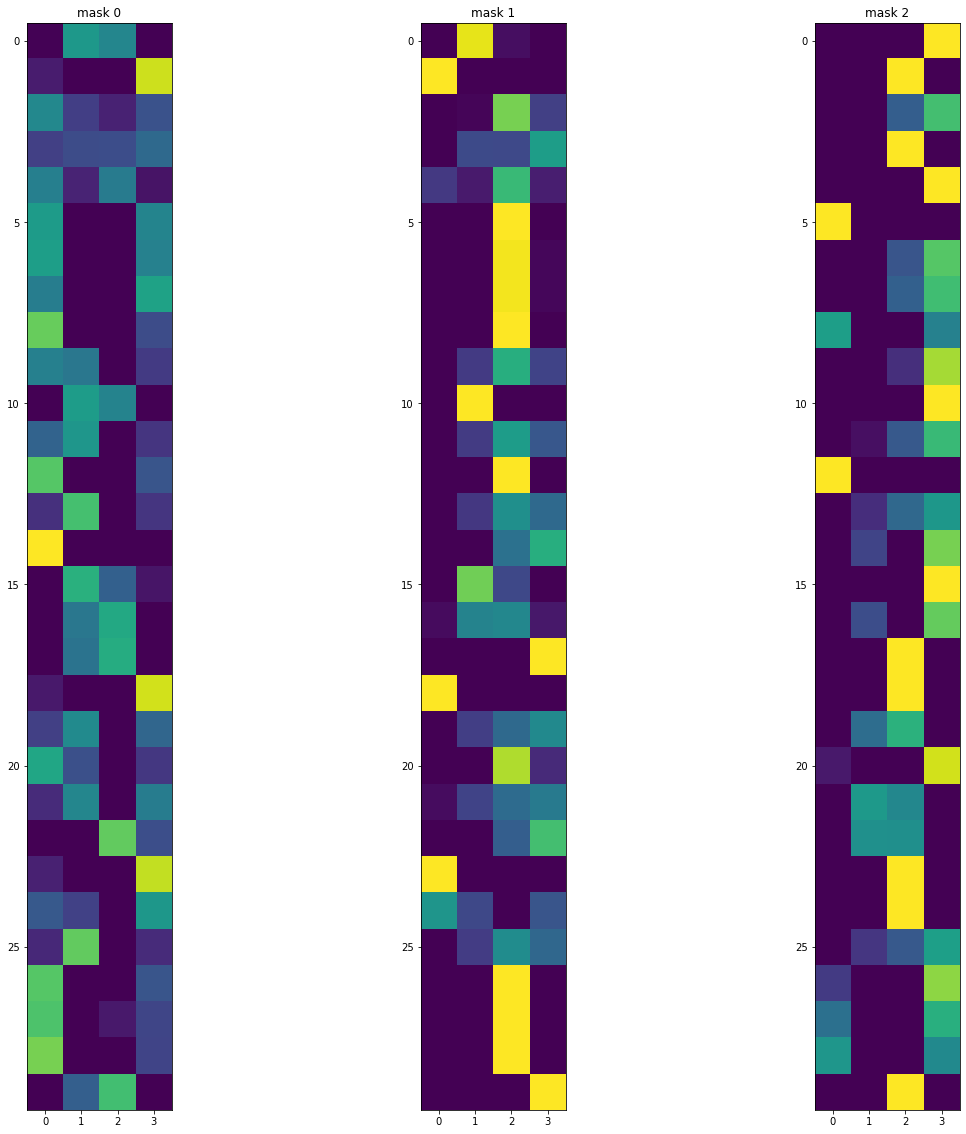

In [142]:
explain_matrix, masks = clf.explain(X_test.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

## Benchmark: XGBoost

In [148]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=1e-3,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='multi:softmax',
    num_class=3,
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-merror:0.055556
Will train until validation_0-merror hasn't improved in 40 rounds.
[10]	validation_0-merror:0.055556
[20]	validation_0-merror:0.055556
[30]	validation_0-merror:0.055556
[40]	validation_0-merror:0.055556
Stopping. Best iteration:
[0]	validation_0-merror:0.055556



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, num_class=3, objective='multi:softmax',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=0)

In [146]:
preds = np.array(clf_xgb.predict(X_valid))
valid_score = balanced_accuracy_score(y_pred=preds, y_true=y_valid)
print(valid_score)

preds = np.array(clf_xgb.predict(X_test))
test_score = balanced_accuracy_score(y_pred=preds, y_true=y_test)
print(test_score)

0.9444444444444445
0.9333333333333332
